In [2]:

%load_ext autoreload
%autoreload 2

import numpy as np
from signal_model import NeuroNet
import re
from pathlib import Path
from dataset.signal_dataset import SignalDataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [3]:


sample_rate = 1562500
channel_1 = 'ch1'
channel_2 = 'ch2'
channel_3 = 'ch3'
signal_data_dir = "/mnt/home2/Motor_project/AE_PETR_loziska/"
train_config = ([{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_1 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_1 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
                +
                [{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_2 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_2 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
                +
                [{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_3 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_3 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)])

test_config = ([{"label": (int(i.stem) - 1) // 4,
                 "channels": len(list(i.glob('*' + channel_1 + '.bin'))),
                 "interval": [int(4.5 * sample_rate), int(5 * sample_rate)],
                 "bin_path": list(i.glob('*' + channel_1 + '.bin'))[0]}
                for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
               +
               [{"label": (int(i.stem) - 1) // 4,
                 "channels": len(list(i.glob('*' + channel_2 + '.bin'))),
                 "interval": [int(4.5 * sample_rate), int(5 * sample_rate)],
                 "bin_path": list(i.glob('*' + channel_2 + '.bin'))[0]}
                for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]
               +
               [{"label": (int(i.stem) - 1) // 4,
                 "channels": len(list(i.glob('*' + channel_3 + '.bin'))),
                 "interval": [int(4.5 * sample_rate), int(5 * sample_rate)],
                 "bin_path": list(i.glob('*' + channel_3 + '.bin'))[0]}
                for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)])

In [4]:
noise_config = {"intensity": 1,
                "bin_path": Path("/mnt/home2/Motor_project/AE_PETR_loziska/prevodovka/AE-DATA-conti-7394086655261458-ch1.bin")}

train_set = SignalDataset(step=10000, window_size=10000, bin_setup=train_config, source_dtype="float32")
test_set = SignalDataset(step=10000, window_size=10000, bin_setup=test_config, source_dtype="float32")


In [5]:
len(train_set)

48507

In [13]:
def get_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    mean = 0.0
    std = 0.0
    nb_samples = 0
    
    for data in loader:
        batch_samples = data[0].shape[0] # batch size (the last batch can have smaller size)
        # data = data.view(batch_samples, data[0].shape(1), -1)
        mean += data[0]._mean(2).sum(0)
        std += data[0]._std(2).sum(0)
        nb_samples += batch_samples
    print(nb_samples)
    mean /= nb_samples
    std /= nb_samples
    
    return mean, std

# Assuming your dataset is created and named custom_dataset
mean, std = get_mean_and_std(train_set)

print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

AttributeError: 'Tensor' object has no attribute '_mean'

In [28]:
test_mean, test_std = get_mean_and_std(test_set)
print(f'Mean: {test_mean}')
print(f'Standard Deviation: {test_std}')

NameError: name 'test_set' is not defined

In [16]:
signal.shape

(10000,)

/tmp/ipykernel_81100/3097464760.py:92: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


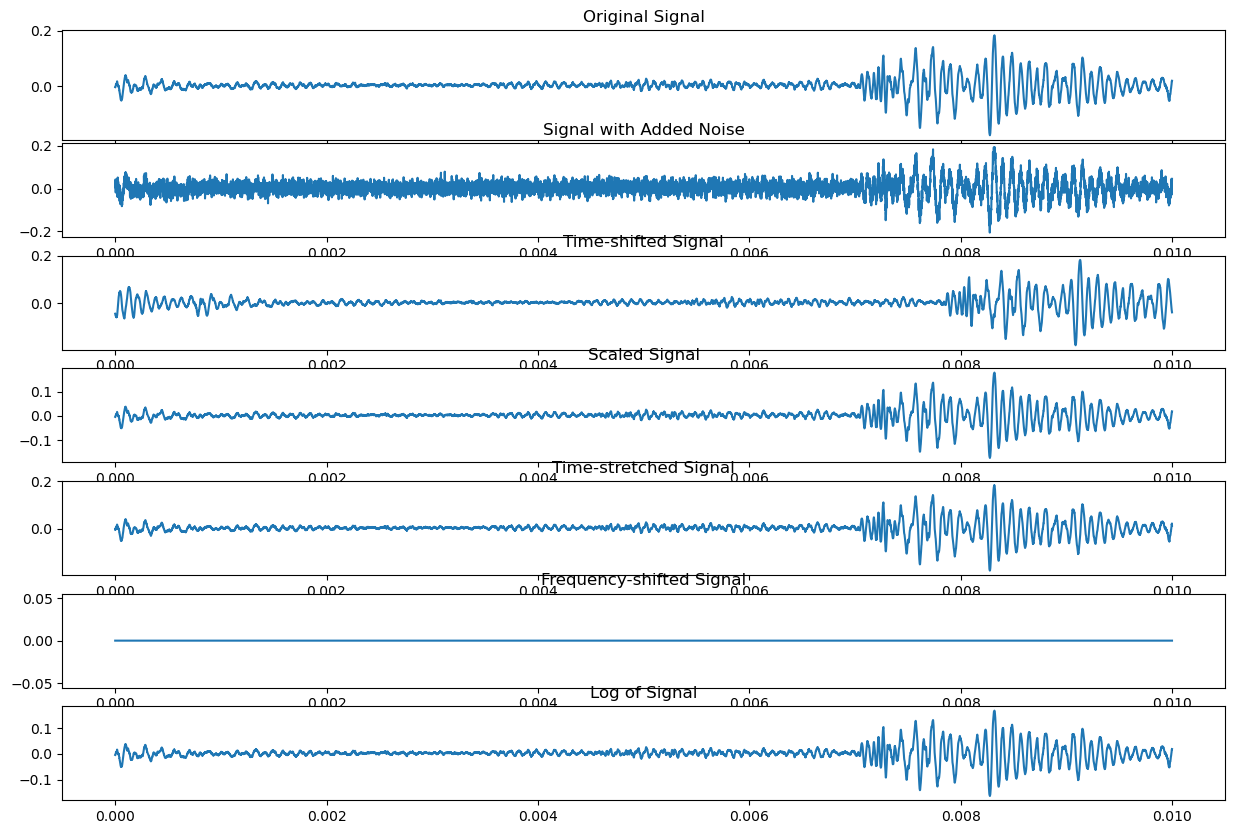

In [17]:
import numpy as np
import random
from scipy.ndimage import shift
from scipy.signal import resample

# Function to add noise
def add_noise(signal, noise_level=0.02):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

# Function to shift signal in time
def time_shift(signal, shift_max=0.1):
    shift_amount = int(random.uniform(-shift_max, shift_max) * len(signal))
    return np.roll(signal, shift_amount)

# Function to scale signal
def scale_signal(signal, scale_min=0.8, scale_max=1.2):
    scale_factor = random.uniform(scale_min, scale_max)
    return signal * scale_factor

# Function to stretch or compress signal
def time_stretch(signal, stretch_min=0.1, stretch_max=3):
    stretch_factor = random.uniform(stretch_min, stretch_max)
    return resample(signal, int(len(signal) * stretch_factor))

# Function to apply frequency shift
def frequency_shift(signal, sample_rate, shift_max=0.1):
    shift_amount = int(random.uniform(-shift_max, shift_max) * sample_rate)
    signal_fft = np.fft.fft(signal)
    signal_fft = np.roll(signal_fft, shift_amount)
    if shift_amount > 0:
        signal_fft[:shift_amount] = 0
    else:
        signal_fft[shift_amount:] = 0
    return np.fft.ifft(signal_fft).real
def normalized_signal(signal):
    maximum = np.max(signal)
    minimum = np.min(signal)
    return (signal - minimum)/ (maximum-minimum)
def log(signal):
    return np.sign(signal) * np.log1p(np.abs(signal))

# Example usage
np.random.seed(0)
sample_rate = 1562500
duration = 0.01  # 10 milliseconds
time = np.linspace(0, duration, 10000, endpoint=False)
frequency = 500000  # 500 kHz
signal = train_set[0][0].reshape(-1)

# Apply augmentations
augmented_signal_1 = add_noise(signal)
augmented_signal_6 = log(signal)
augmented_signal_2 = time_shift(signal)
augmented_signal_3 = scale_signal(signal)
augmented_signal_4 = time_stretch(signal)
augmented_signal_5 = frequency_shift(signal, sample_rate)

# Plot original and augmented signals
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(6, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')



plt.subplot(7, 1, 2)
plt.plot(time, augmented_signal_1)
plt.title('Signal with Added Noise')

plt.subplot(7, 1, 3)
plt.plot(time, augmented_signal_2)
plt.title('Time-shifted Signal')

plt.subplot(7, 1, 4)
plt.plot(time, augmented_signal_3)
plt.title('Scaled Signal')

plt.subplot(7, 1, 5)
plt.plot(np.linspace(0, duration, len(augmented_signal_4)), augmented_signal_4)
plt.title('Time-stretched Signal')

plt.subplot(7, 1, 6)
plt.plot(time, augmented_signal_5)
plt.title('Frequency-shifted Signal')

plt.subplot(7, 1, 7)
plt.plot(time, augmented_signal_6)
plt.title('Log of Signal')
plt.tight_layout()

plt.show()

In [25]:
signal = signal.reshape(1,-1).repeat(2, axis=1)

In [ ]:
signal.shape

ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000000,)

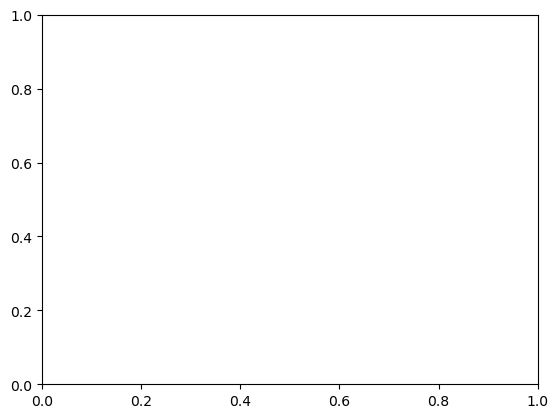

In [19]:
signal = signal.repeat(100, axis=1)
augmented_signal_1 = add_noise(signal,noise_level=0.02)
plt.plot(time, augmented_signal_1)
plt.plot(time, signal)
plt.title('Signal with Added Noise')
plt.show()

In [ ]:

nn_config = load_yaml(Path("nn_configs/CNN_spec.yaml"))
neuro_net = NeuroNet(config=nn_config, tensorboard=True)

neuro_net.train(train_set)



In [ ]:
test_dataloader = DataLoader(test_set, batch_size=512, shuffle=False)
outputs = np.empty((0,), dtype=np.float32)
targets = np.empty((0,), dtype=np.longdouble).flatten()
for i, (input, target) in enumerate(test_dataloader):
    input, target = input.numpy(), target.numpy()
    output = neuro_net.predict(input)
    outputs = np.concatenate((outputs, output), axis=0)
    targets = np.concatenate((targets, target), axis=0)
neuro_net.plot_confusion_matrix(outputs, targets)

In [ ]:
cr = classification_report(targets, outputs, zero_division=0)